In [18]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# ------------------------------
# 1. U-Net Model Definition
# ------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=13):
        super().__init__()
        self.enc1 = DoubleConv(n_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((dec1, enc1), dim=1))

        return self.final_conv(dec1)

# ------------------------------
# 2. Dataset for Image-Mask Pairs
# ------------------------------
class SegmentationDataset(Dataset):
    def __init__(self, root_dir, image_dir='images', mask_dir='labels', transform_img=None, transform_mask=None):
        self.image_paths = sorted(os.listdir(os.path.join(root_dir, image_dir)))
        self.mask_paths = sorted(os.listdir(os.path.join(root_dir, mask_dir)))
        self.image_dir = os.path.join(root_dir, image_dir)
        self.mask_dir = os.path.join(root_dir, mask_dir)
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_paths[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.mask_paths[idx])).convert("L")  # force grayscale
    
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask).squeeze(0)  # shape: [H, W]
    
        return image, mask.long()

# ------------------------------
# 3. Load Data with Transforms
# ------------------------------
def get_dataloaders(data_dir, batch_size=8, val_split=0.2):
    image_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    mask_transform = transforms.Compose([
        transforms.PILToTensor(),  # preserves label indices
    ])

    dataset = SegmentationDataset(root_dir=data_dir, transform_img=image_transform, transform_mask=mask_transform)
    
    val_size = int(val_split * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# ------------------------------
# 4. Set Seed for Reproducibility
# ------------------------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchmetrics.classification import MulticlassJaccardIndex
import matplotlib.pyplot as plt

from torchmetrics.segmentation import MeanIoU

def train_one_epoch(model, loader, optimizer, criterion, miou, device):
    model.train()
    epoch_loss, epoch_miou = 0.0, 0.0
    miou.reset()

    for images, masks in tqdm(loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        miou.update(outputs.argmax(1), masks)

    return epoch_loss / len(loader), miou.compute().item()
    
def evaluate_model(model, loader, criterion, miou, device):
    model.eval()
    epoch_loss, epoch_miou = 0.0, 0.0
    miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
            miou.update(outputs.argmax(1), masks)

    return epoch_loss / len(loader), miou.compute().item()

def train_model(model, train_loader, val_loader, device, num_classes=13, epochs=50, lr=1e-3, save_path="best_model.pth"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    miou_metric = MeanIoU(num_classes=num_classes).to(device)

    best_val_miou = 0.0
    train_losses, val_losses, train_ious, val_ious = [], [], [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, train_miou = train_one_epoch(model, train_loader, optimizer, criterion, miou_metric, device)
        val_loss, val_miou = evaluate_model(model, val_loader, criterion, miou_metric, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_miou)
        val_ious.append(val_miou)

        print(f"Train Loss: {train_loss:.4f} | mIoU: {train_miou:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | mIoU: {val_miou:.4f}")

        if val_miou > best_val_miou:
            best_val_miou = val_miou
            torch.save(model.state_dict(), save_path)
            print(f" Best model saved to {save_path}")

    return train_losses, val_losses, train_ious, val_ious
# # ------------------------------
# # 1. Training & Validation Loops
# # ------------------------------
# def train_model(model, train_loader, val_loader, device, num_classes=13, epochs=50):
#     optimizer = optim.Adam(model.parameters(), lr=1e-3)
#     criterion = nn.CrossEntropyLoss()
#     miou_metric = MulticlassJaccardIndex(num_classes=num_classes).to(device)

#     train_losses, val_losses, train_ious, val_ious = [], [], [], []

#     for epoch in range(epochs):
#         model.train()
#         running_loss, running_iou = 0.0, 0.0
#         for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
#             images, masks = images.to(device), masks.squeeze(1).to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             running_iou += miou_metric(outputs.argmax(1), masks).item()

#         train_losses.append(running_loss / len(train_loader))
#         train_ious.append(running_iou / len(train_loader))

#         # Validation
#         model.eval()
#         val_loss, val_iou = 0.0, 0.0
#         with torch.no_grad():
#             for images, masks in tqdm(val_loader, desc="Validation"):
#                 images, masks = images.to(device), masks.squeeze(1).to(device)
#                 outputs = model(images)
#                 val_loss += criterion(outputs, masks).item()
#                 val_iou += miou_metric(outputs.argmax(1), masks).item()

#         val_losses.append(val_loss / len(val_loader))
#         val_ious.append(val_iou / len(val_loader))

#         print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, mIoU: {train_ious[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}, mIoU: {val_ious[-1]:.4f}")

#     return train_losses, val_losses, train_ious, val_ious

# # ------------------------------
# # 2. Plotting Loss & mIoU Curves
# # ------------------------------
# def plot_curves(train_losses, val_losses, train_ious, val_ious):
#     plt.figure(figsize=(12, 4))

#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(val_losses, label='Val Loss')
#     plt.title("Loss Curve")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(train_ious, label='Train mIoU')
#     plt.plot(val_ious, label='Val mIoU')
#     plt.title("mIoU Curve")
#     plt.xlabel("Epoch")
#     plt.ylabel("mIoU")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

def plot_curves(train_losses, val_losses, train_ious, val_ious):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_ious, label='Train mIoU')
    plt.plot(val_ious, label='Val mIoU')
    plt.title("mIoU Curve")
    plt.xlabel("Epoch")
    plt.ylabel("mIoU")
    plt.legend()

    plt.tight_layout()
    plt.show()

# # ------------------------------
# # 3. Evaluate on Test Set
# # ------------------------------
# def evaluate_on_test(model, test_loader, device, num_classes=13):
#     model.eval()
#     miou = MulticlassJaccardIndex(num_classes=num_classes).to(device)
#     total_iou = 0.0
#     with torch.no_grad():
#         for images, masks in tqdm(test_loader, desc="Testing"):
#             images = images.to(device)
#             masks = masks.squeeze(1).to(device)
#             outputs = model(images)
#             total_iou += miou(outputs.argmax(1), masks).item()
#     avg_miou = total_iou / len(test_loader)
#     print(f"\n mIoU on Test Set: {avg_miou:.4f}")
#     return avg_miou

# def evaluate_on_test(model, test_loader, device, num_classes=13):
#     model.eval()
#     miou = MeanIoU(num_classes=num_classes).to(device)
#     miou.reset()

#     with torch.no_grad():
#         for images, masks in tqdm(test_loader, desc="Testing"):
#             images = images.to(device)
#             masks = masks.to(device)
#             outputs = model(images)
#             miou.update(outputs.argmax(1), masks)

#     avg_miou = miou.compute().item()
#     print(f"\n Test mIoU: {avg_miou:.4f}")
#     return avg_miou
    
def evaluate_on_test(model,test_loader, device, checkpoint_path,num_classes=13):
    # Initialize model and load weights
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    # Initialize mIoU metric
    miou = MeanIoU(num_classes=num_classes).to(device)
    miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            miou.update(outputs.argmax(1), masks)

    avg_miou = miou.compute().item()
    print(f"\n Test mIoU (from {checkpoint_path}): {avg_miou:.4f}")
    return avg_miou

# # ------------------------------
# # 4. Visualize Predictions
# # ------------------------------
# def visualize_predictions(model, test_loader, device, num_samples=3):
#     model.eval()
#     images, masks = next(iter(test_loader))
#     images = images.to(device)
#     outputs = model(images)
#     preds = outputs.argmax(1).cpu()

#     for i in range(num_samples):
#         fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#         axs[0].imshow(images[i].permute(1, 2, 0).cpu())
#         axs[0].set_title("Input Image")
#         axs[1].imshow(masks[i].squeeze(), cmap='tab20')
#         axs[1].set_title("Ground Truth")
#         axs[2].imshow(preds[i], cmap='tab20')
#         axs[2].set_title("Prediction")
#         for ax in axs: ax.axis('off')
#         plt.show()

def visualize_predictions(model, test_loader, device, num_samples=3):
    model.eval()
    images, masks = next(iter(test_loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(1).cpu()

    for i in range(num_samples):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(images[i].permute(1, 2, 0).cpu())
        axs[0].set_title("Input Image")
        axs[1].imshow(masks[i], cmap='tab20')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(preds[i], cmap='tab20')
        axs[2].set_title("Prediction")
        for ax in axs: ax.axis("off")
        plt.show()


In [23]:
# from unet_kaggle_setup import UNet, get_dataloaders
# from train_eval_unet import train_model, plot_curves, evaluate_on_test, visualize_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=13).to(device)

train_loader, val_loader = get_dataloaders("/kaggle/input/cv-a4-unet-dataset/dataset_256/train", batch_size=8)
test_loader = get_dataloaders("/kaggle/input/cv-a4-unet-dataset/dataset_256/test", batch_size=8, val_split=0.0)[0]




In [24]:
# Train
train_losses, val_losses, train_ious, val_ious = train_model(model, train_loader, val_loader, device, epochs=50, save_path="unet_best.pth")


Epoch 1/50


Train Loss: 1.1105 | mIoU: 0.4603
Val   Loss: 0.4186 | mIoU: 0.6072
 Best model saved to unet_best.pth

Epoch 2/50


Train Loss: 0.3343 | mIoU: 0.6736
Val   Loss: 0.2878 | mIoU: 0.6896
 Best model saved to unet_best.pth

Epoch 3/50


Train Loss: 0.2585 | mIoU: 0.7036
Val   Loss: 0.2517 | mIoU: 0.7215
 Best model saved to unet_best.pth

Epoch 4/50


Train Loss: 0.2220 | mIoU: 0.7235
Val   Loss: 0.2016 | mIoU: 0.7341
 Best model saved to unet_best.pth

Epoch 5/50


Train Loss: 0.2317 | mIoU: 0.7242
Val   Loss: 0.1966 | mIoU: 0.7297

Epoch 6/50


Train Loss: 0.2061 | mIoU: 0.7355
Val   Loss: 0.1888 | mIoU: 0.7472
 Best model saved to unet_best.pth

Epoch 7/50


Train Loss: 0.1739 | mIoU: 0.7558
Val   Loss: 0.1636 | mIoU: 0.7593
 Best model saved to unet_best.pth

Epoch 8/50


Train Loss: 0.1577 | mIoU: 0.7682
Val   Loss: 0.1508 | mIoU: 0.7681
 Best model saved to unet_best.pth

Epoch 9/50


Train Loss: 0.1431 | mIoU: 0.7781
Val   Loss: 0.1455 | mIoU: 0.7656

Epoch 10/50


Train Loss: 0.1304 | mIoU: 0.7882
Val   Loss: 0.1224 | mIoU: 0.7919
 Best model saved to unet_best.pth

Epoch 11/50


Train Loss: 0.1215 | mIoU: 0.7951
Val   Loss: 0.1914 | mIoU: 0.7519

Epoch 12/50


Train Loss: 0.1184 | mIoU: 0.7976
Val   Loss: 0.1131 | mIoU: 0.7980
 Best model saved to unet_best.pth

Epoch 13/50


Train Loss: 0.5172 | mIoU: 0.6912
Val   Loss: 0.7291 | mIoU: 0.5988

Epoch 14/50


Train Loss: 0.6728 | mIoU: 0.6261
Val   Loss: 0.4901 | mIoU: 0.6435

Epoch 15/50


Train Loss: 0.4343 | mIoU: 0.6626
Val   Loss: 0.3207 | mIoU: 0.6873

Epoch 16/50


Train Loss: 0.2869 | mIoU: 0.7146
Val   Loss: 0.2298 | mIoU: 0.7354

Epoch 17/50


Train Loss: 0.2177 | mIoU: 0.7455
Val   Loss: 0.2010 | mIoU: 0.7459

Epoch 18/50


Train Loss: 0.1886 | mIoU: 0.7612
Val   Loss: 0.1701 | mIoU: 0.7589

Epoch 19/50


Train Loss: 0.1691 | mIoU: 0.7705
Val   Loss: 0.1911 | mIoU: 0.7524

Epoch 20/50


Train Loss: 0.1541 | mIoU: 0.7791
Val   Loss: 0.1406 | mIoU: 0.7763

Epoch 21/50


Train Loss: 0.1325 | mIoU: 0.7915
Val   Loss: 0.1294 | mIoU: 0.7890

Epoch 22/50


Train Loss: 0.1225 | mIoU: 0.7989
Val   Loss: 0.1192 | mIoU: 0.7929

Epoch 23/50


Train Loss: 0.1127 | mIoU: 0.8055
Val   Loss: 0.1184 | mIoU: 0.7973

Epoch 24/50


Train Loss: 0.1414 | mIoU: 0.7919
Val   Loss: 0.1114 | mIoU: 0.8011
 Best model saved to unet_best.pth

Epoch 25/50


Train Loss: 0.1003 | mIoU: 0.8141
Val   Loss: 0.1032 | mIoU: 0.8033
 Best model saved to unet_best.pth

Epoch 26/50


Train Loss: 0.0933 | mIoU: 0.8185
Val   Loss: 0.0987 | mIoU: 0.8065
 Best model saved to unet_best.pth

Epoch 27/50


Train Loss: 0.0855 | mIoU: 0.8232
Val   Loss: 0.0917 | mIoU: 0.8118
 Best model saved to unet_best.pth

Epoch 28/50


Train Loss: 0.0796 | mIoU: 0.8274
Val   Loss: 0.0865 | mIoU: 0.8153
 Best model saved to unet_best.pth

Epoch 29/50


Train Loss: 0.0912 | mIoU: 0.8212
Val   Loss: 0.0873 | mIoU: 0.8137

Epoch 30/50


Train Loss: 0.0737 | mIoU: 0.8309
Val   Loss: 0.0838 | mIoU: 0.8178
 Best model saved to unet_best.pth

Epoch 31/50


Train Loss: 0.0705 | mIoU: 0.8335
Val   Loss: 0.0835 | mIoU: 0.8185
 Best model saved to unet_best.pth

Epoch 32/50


Train Loss: 0.0645 | mIoU: 0.8374
Val   Loss: 0.0769 | mIoU: 0.8229
 Best model saved to unet_best.pth

Epoch 33/50


Train Loss: 0.0692 | mIoU: 0.8346
Val   Loss: 0.0765 | mIoU: 0.8223

Epoch 34/50


Train Loss: 0.0599 | mIoU: 0.8406
Val   Loss: 0.0775 | mIoU: 0.8241
 Best model saved to unet_best.pth

Epoch 35/50


Train Loss: 0.0565 | mIoU: 0.8430
Val   Loss: 0.0754 | mIoU: 0.8249
 Best model saved to unet_best.pth

Epoch 36/50


Train Loss: 0.0556 | mIoU: 0.8435
Val   Loss: 0.0754 | mIoU: 0.8248

Epoch 37/50


Train Loss: 0.0560 | mIoU: 0.8434
Val   Loss: 0.0743 | mIoU: 0.8258
 Best model saved to unet_best.pth

Epoch 38/50


Train Loss: 0.1613 | mIoU: 0.7925
Val   Loss: 0.1348 | mIoU: 0.7888

Epoch 39/50


Train Loss: 0.0893 | mIoU: 0.8207
Val   Loss: 0.0788 | mIoU: 0.8213

Epoch 40/50


Train Loss: 0.0611 | mIoU: 0.8393
Val   Loss: 0.0713 | mIoU: 0.8260
 Best model saved to unet_best.pth

Epoch 41/50


Train Loss: 0.0537 | mIoU: 0.8446
Val   Loss: 0.0678 | mIoU: 0.8292
 Best model saved to unet_best.pth

Epoch 42/50


Train Loss: 0.0497 | mIoU: 0.8479
Val   Loss: 0.0679 | mIoU: 0.8302
 Best model saved to unet_best.pth

Epoch 43/50


Train Loss: 0.0476 | mIoU: 0.8494
Val   Loss: 0.0669 | mIoU: 0.8312
 Best model saved to unet_best.pth

Epoch 44/50


Train Loss: 0.0539 | mIoU: 0.8462
Val   Loss: 0.0775 | mIoU: 0.8245

Epoch 45/50


Train Loss: 0.0496 | mIoU: 0.8477
Val   Loss: 0.0638 | mIoU: 0.8331
 Best model saved to unet_best.pth

Epoch 46/50


Train Loss: 0.0430 | mIoU: 0.8531
Val   Loss: 0.0640 | mIoU: 0.8329

Epoch 47/50


Train Loss: 0.0407 | mIoU: 0.8548
Val   Loss: 0.0622 | mIoU: 0.8347
 Best model saved to unet_best.pth

Epoch 48/50


Train Loss: 0.0403 | mIoU: 0.8551
Val   Loss: 0.0629 | mIoU: 0.8344

Epoch 49/50


Train Loss: 0.0392 | mIoU: 0.8560
Val   Loss: 0.0617 | mIoU: 0.8354
 Best model saved to unet_best.pth

Epoch 50/50


Train Loss: 0.0373 | mIoU: 0.8573
Val   Loss: 0.0604 | mIoU: 0.8364
 Best model saved to unet_best.pth


In [27]:
# # Save model weights
# torch.save(model.state_dict(), "unet_vanilla.pth")
# print(" Model weights saved to unet_vanilla.pth")


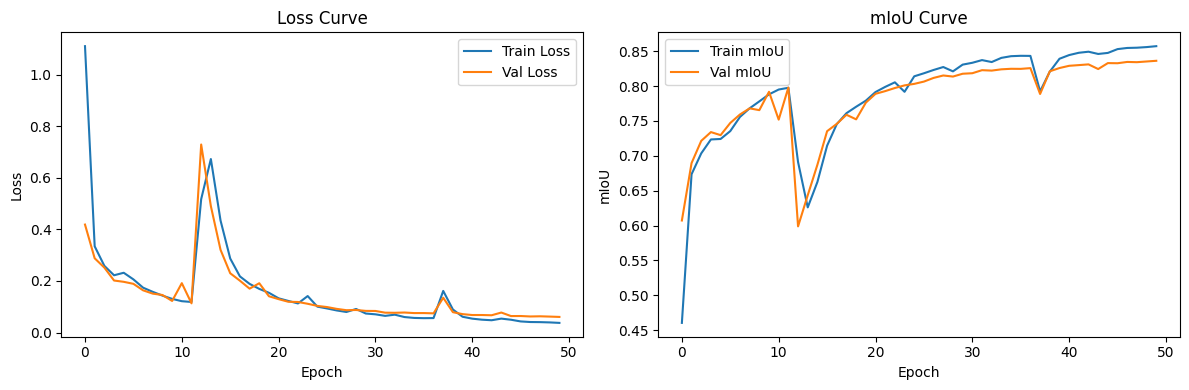

In [25]:
# Plot
plot_curves(train_losses, val_losses, train_ious, val_ious)

In [47]:
# Evaluate
evaluate_on_test(model, test_loader, device, checkpoint_path="/kaggle/working/unet_best.pth")

<ipython-input-46-8cfcfcc2678f>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))
Testing: 100%|████


 Test mIoU (from /kaggle/working/unet_best.pth): 0.8399


0.8399471640586853

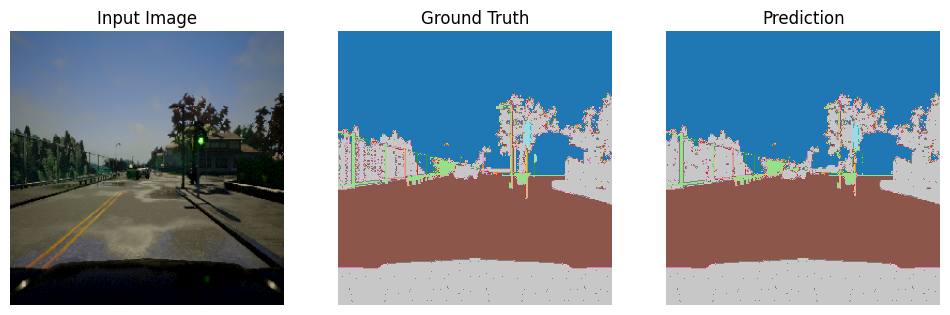

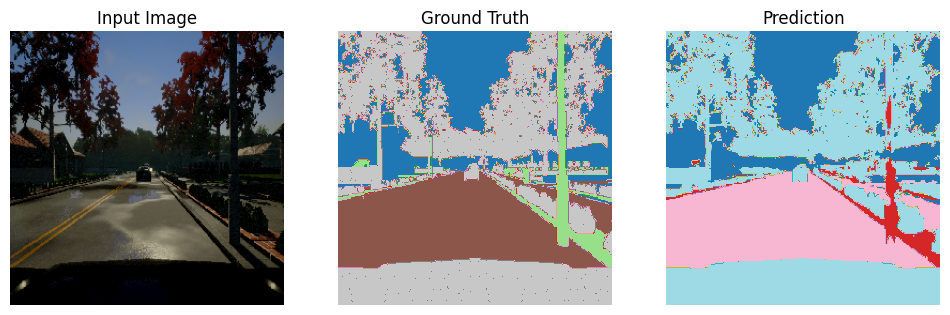

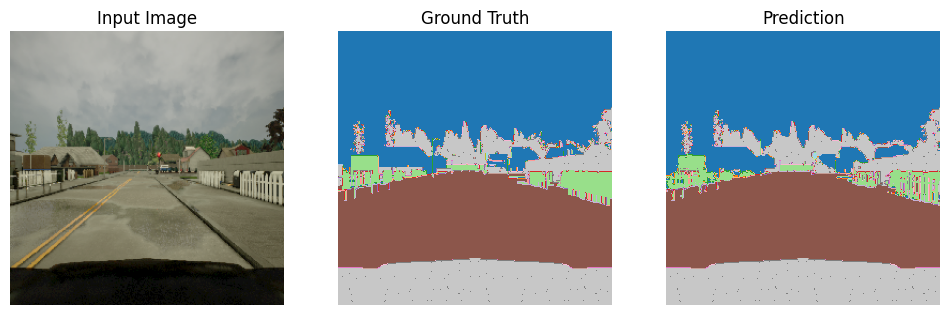

In [28]:
# Visualize
visualize_predictions(model, test_loader, device)

## 2. Unet without SKip connections

In [32]:
# class UNetNoSkip(nn.Module):
#     def __init__(self, n_channels=3, n_classes=13):
#         super().__init__()
#         self.enc1 = DoubleConv(n_channels, 64)
#         self.enc2 = DoubleConv(64, 128)
#         self.enc3 = DoubleConv(128, 256)
#         self.enc4 = DoubleConv(256, 512)
#         self.bottleneck = DoubleConv(512, 1024)

#         self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
#         self.dec4 = DoubleConv(512, 512)
#         self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.dec3 = DoubleConv(256, 256)
#         self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.dec2 = DoubleConv(128, 128)
#         self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.dec1 = DoubleConv(64, 64)

#         self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

#     def forward(self, x):
#         x1 = self.enc1(x)
#         x2 = self.enc2(nn.MaxPool2d(2)(x1))
#         x3 = self.enc3(nn.MaxPool2d(2)(x2))
#         x4 = self.enc4(nn.MaxPool2d(2)(x3))
#         x5 = self.bottleneck(nn.MaxPool2d(2)(x4))

#         x = self.upconv4(x5)
#         x = self.dec4(x)  # no concat with x4

#         x = self.upconv3(x)
#         x = self.dec3(x)  # no concat with x3

#         x = self.upconv2(x)
#         x = self.dec2(x)  # no concat with x2

#         x = self.upconv1(x)
#         x = self.dec1(x)  # no concat with x1

#         return self.final_conv(x)

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """Two Conv3x3 + ReLU layers"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetNoSkip(nn.Module):
    def __init__(self, n_channels=3, n_classes=13):
        super(UNetNoSkip, self).__init__()
        
        # Encoder
        self.enc1 = DoubleConv(n_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        # Decoder (adjusted input channels: no concat!)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(512, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(128, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(64, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)      # [B, 64, 256, 256]
        x2 = self.enc2(self.pool1(x1))  # [B, 128, 128, 128]
        x3 = self.enc3(self.pool2(x2))  # [B, 256, 64, 64]
        x4 = self.enc4(self.pool3(x3))  # [B, 512, 32, 32]
        x5 = self.bottleneck(self.pool4(x4))  # [B, 1024, 16, 16]

        # Decoder (no skip connections)
        x = self.upconv4(x5)  # [B, 512, 32, 32]
        x = self.dec4(x)

        x = self.upconv3(x)   # [B, 256, 64, 64]
        x = self.dec3(x)

        x = self.upconv2(x)   # [B, 128, 128, 128]
        x = self.dec2(x)

        x = self.upconv1(x)   # [B, 64, 256, 256]
        x = self.dec1(x)

        return self.final_conv(x)  # [B, 13, 256, 256]



In [33]:
# # Reuse previous dataloaders
# train_loader, val_loader = get_dataloaders("/kaggle/input/your-dataset/train", batch_size=8)
# test_loader = get_dataloaders("/kaggle/input/your-dataset/test", batch_size=8, val_split=0.0)[0]

# Initialize and train the U-Net without skip connections
model_no_skip = UNetNoSkip(n_channels=3, n_classes=13).to(device)



In [34]:
train_losses_noskip, val_losses_noskip, train_ious_noskip, val_ious_noskip = train_model(
    model_no_skip, train_loader, val_loader, device, epochs=50, save_path="unetNoSkip_best.pth"
)


Epoch 1/50


Train Loss: 1.2872 | mIoU: 0.1934
Val   Loss: 0.7902 | mIoU: 0.5290
 Best model saved to unetNoSkip_best.pth

Epoch 2/50


Train Loss: 0.4779 | mIoU: 0.5704
Val   Loss: 0.3741 | mIoU: 0.6427
 Best model saved to unetNoSkip_best.pth

Epoch 3/50


Train Loss: 0.3226 | mIoU: 0.6365
Val   Loss: 0.3000 | mIoU: 0.6421

Epoch 4/50


Train Loss: 0.2865 | mIoU: 0.6593
Val   Loss: 0.2761 | mIoU: 0.6618
 Best model saved to unetNoSkip_best.pth

Epoch 5/50


Train Loss: 0.2612 | mIoU: 0.6766
Val   Loss: 0.2468 | mIoU: 0.6807
 Best model saved to unetNoSkip_best.pth

Epoch 6/50


Train Loss: 0.2362 | mIoU: 0.6916
Val   Loss: 0.2317 | mIoU: 0.6949
 Best model saved to unetNoSkip_best.pth

Epoch 7/50


Train Loss: 0.2220 | mIoU: 0.6993
Val   Loss: 0.2160 | mIoU: 0.6931

Epoch 8/50


Train Loss: 0.2069 | mIoU: 0.7080
Val   Loss: 0.2032 | mIoU: 0.7058
 Best model saved to unetNoSkip_best.pth

Epoch 9/50


Train Loss: 0.1924 | mIoU: 0.7156
Val   Loss: 0.2153 | mIoU: 0.7079
 Best model saved to unetNoSkip_best.pth

Epoch 10/50


Train Loss: 0.1834 | mIoU: 0.7212
Val   Loss: 0.1850 | mIoU: 0.7168
 Best model saved to unetNoSkip_best.pth

Epoch 11/50


Train Loss: 0.1710 | mIoU: 0.7278
Val   Loss: 0.1764 | mIoU: 0.7218
 Best model saved to unetNoSkip_best.pth

Epoch 12/50


Train Loss: 0.1642 | mIoU: 0.7324
Val   Loss: 0.1729 | mIoU: 0.7263
 Best model saved to unetNoSkip_best.pth

Epoch 13/50


Train Loss: 0.1546 | mIoU: 0.7375
Val   Loss: 0.1598 | mIoU: 0.7270
 Best model saved to unetNoSkip_best.pth

Epoch 14/50


Train Loss: 0.1564 | mIoU: 0.7376
Val   Loss: 0.1582 | mIoU: 0.7278
 Best model saved to unetNoSkip_best.pth

Epoch 15/50


Train Loss: 0.1423 | mIoU: 0.7468
Val   Loss: 0.1516 | mIoU: 0.7328
 Best model saved to unetNoSkip_best.pth

Epoch 16/50


Train Loss: 0.1352 | mIoU: 0.7523
Val   Loss: 0.1463 | mIoU: 0.7382
 Best model saved to unetNoSkip_best.pth

Epoch 17/50


Train Loss: 0.1388 | mIoU: 0.7493
Val   Loss: 0.1482 | mIoU: 0.7405
 Best model saved to unetNoSkip_best.pth

Epoch 18/50


Train Loss: 0.1283 | mIoU: 0.7576
Val   Loss: 0.1447 | mIoU: 0.7457
 Best model saved to unetNoSkip_best.pth

Epoch 19/50


Train Loss: 0.1250 | mIoU: 0.7600
Val   Loss: 0.1398 | mIoU: 0.7411

Epoch 20/50


Train Loss: 0.1199 | mIoU: 0.7639
Val   Loss: 0.1395 | mIoU: 0.7449

Epoch 21/50


Train Loss: 0.1168 | mIoU: 0.7672
Val   Loss: 0.1372 | mIoU: 0.7449

Epoch 22/50


Train Loss: 0.1153 | mIoU: 0.7693
Val   Loss: 0.1420 | mIoU: 0.7500
 Best model saved to unetNoSkip_best.pth

Epoch 23/50


Train Loss: 0.1169 | mIoU: 0.7673
Val   Loss: 0.1330 | mIoU: 0.7536
 Best model saved to unetNoSkip_best.pth

Epoch 24/50


Train Loss: 0.1092 | mIoU: 0.7739
Val   Loss: 0.1318 | mIoU: 0.7572
 Best model saved to unetNoSkip_best.pth

Epoch 25/50


Train Loss: 0.1059 | mIoU: 0.7771
Val   Loss: 0.1319 | mIoU: 0.7532

Epoch 26/50


Train Loss: 0.1046 | mIoU: 0.7781
Val   Loss: 0.1301 | mIoU: 0.7561

Epoch 27/50


Train Loss: 0.1029 | mIoU: 0.7796
Val   Loss: 0.1274 | mIoU: 0.7578
 Best model saved to unetNoSkip_best.pth

Epoch 28/50


Train Loss: 0.1015 | mIoU: 0.7811
Val   Loss: 0.1290 | mIoU: 0.7590
 Best model saved to unetNoSkip_best.pth

Epoch 29/50


Train Loss: 0.1000 | mIoU: 0.7823
Val   Loss: 0.1257 | mIoU: 0.7596
 Best model saved to unetNoSkip_best.pth

Epoch 30/50


Train Loss: 0.0999 | mIoU: 0.7821
Val   Loss: 0.1264 | mIoU: 0.7566

Epoch 31/50


Train Loss: 0.0962 | mIoU: 0.7854
Val   Loss: 0.1267 | mIoU: 0.7626
 Best model saved to unetNoSkip_best.pth

Epoch 32/50


Train Loss: 0.0962 | mIoU: 0.7861
Val   Loss: 0.1282 | mIoU: 0.7593

Epoch 33/50


Train Loss: 0.0942 | mIoU: 0.7876
Val   Loss: 0.1234 | mIoU: 0.7655
 Best model saved to unetNoSkip_best.pth

Epoch 34/50


Train Loss: 0.0905 | mIoU: 0.7907
Val   Loss: 0.1246 | mIoU: 0.7627

Epoch 35/50


Train Loss: 0.0889 | mIoU: 0.7919
Val   Loss: 0.1235 | mIoU: 0.7624

Epoch 36/50


Train Loss: 0.0877 | mIoU: 0.7938
Val   Loss: 0.1244 | mIoU: 0.7659
 Best model saved to unetNoSkip_best.pth

Epoch 37/50


Train Loss: 0.0866 | mIoU: 0.7945
Val   Loss: 0.1270 | mIoU: 0.7636

Epoch 38/50


Train Loss: 0.1258 | mIoU: 0.7666
Val   Loss: 0.1323 | mIoU: 0.7582

Epoch 39/50


Train Loss: 0.0917 | mIoU: 0.7904
Val   Loss: 0.1216 | mIoU: 0.7645

Epoch 40/50


Train Loss: 0.0840 | mIoU: 0.7969
Val   Loss: 0.1205 | mIoU: 0.7667
 Best model saved to unetNoSkip_best.pth

Epoch 41/50


Train Loss: 0.0807 | mIoU: 0.7993
Val   Loss: 0.1220 | mIoU: 0.7687
 Best model saved to unetNoSkip_best.pth

Epoch 42/50


Train Loss: 0.0792 | mIoU: 0.8013
Val   Loss: 0.1212 | mIoU: 0.7680

Epoch 43/50


Train Loss: 0.0784 | mIoU: 0.8022
Val   Loss: 0.1238 | mIoU: 0.7687

Epoch 44/50


Train Loss: 0.0777 | mIoU: 0.8022
Val   Loss: 0.1241 | mIoU: 0.7689
 Best model saved to unetNoSkip_best.pth

Epoch 45/50


Train Loss: 0.0774 | mIoU: 0.8027
Val   Loss: 0.1233 | mIoU: 0.7661

Epoch 46/50


Train Loss: 0.0766 | mIoU: 0.8035
Val   Loss: 0.1219 | mIoU: 0.7682

Epoch 47/50


Train Loss: 0.0759 | mIoU: 0.8045
Val   Loss: 0.1221 | mIoU: 0.7708
 Best model saved to unetNoSkip_best.pth

Epoch 48/50


Train Loss: 0.0760 | mIoU: 0.8045
Val   Loss: 0.1202 | mIoU: 0.7696

Epoch 49/50


Train Loss: 0.0747 | mIoU: 0.8056
Val   Loss: 0.1223 | mIoU: 0.7708

Epoch 50/50


Train Loss: 0.0748 | mIoU: 0.8057
Val   Loss: 0.1204 | mIoU: 0.7700


In [8]:
# # Save the model
# torch.save(model_no_skip.state_dict(), "unet_no_skip.pth")

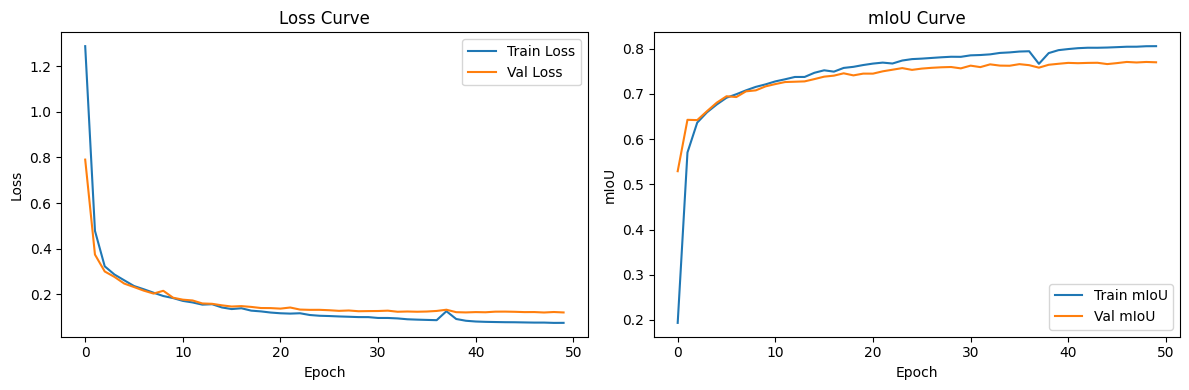

In [37]:
# Plot
plot_curves(train_losses_noskip, val_losses_noskip, train_ious_noskip, val_ious_noskip)

In [48]:
# Evaluate on test set
evaluate_on_test(model_no_skip, test_loader, device, checkpoint_path="/kaggle/working/unetNoSkip_best.pth")

<ipython-input-46-8cfcfcc2678f>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))
Testing: 100%|████


 Test mIoU (from /kaggle/working/unetNoSkip_best.pth): 0.7721


0.7720673084259033

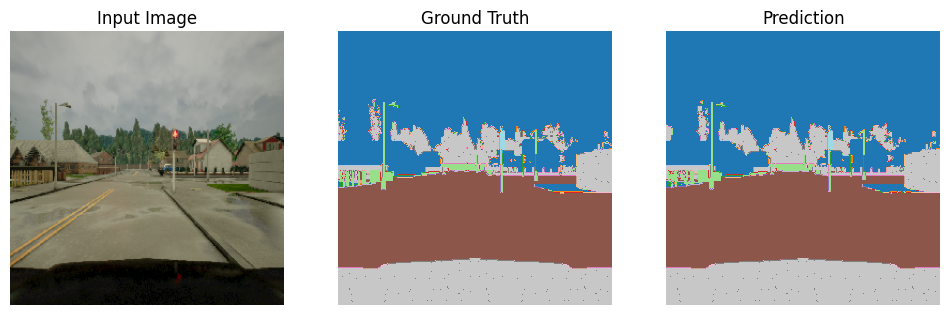

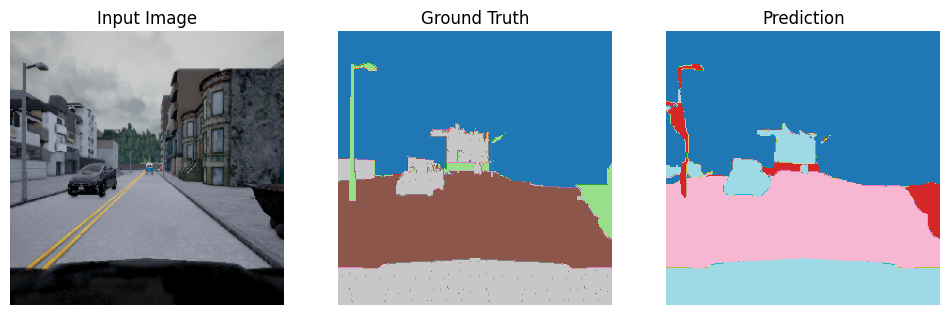

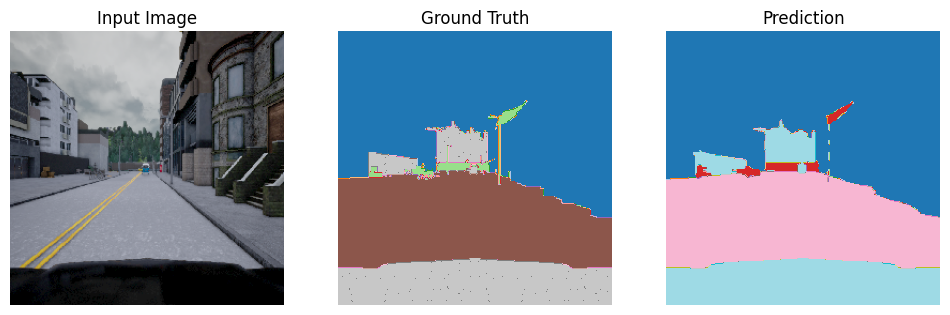

In [36]:
# Visualize predictions
visualize_predictions(model_no_skip, test_loader, device)

### Q1. What differences do you observe in the visualized results compared to the standard U-Net results?

* Sharper predictions: Standard U-Net captures finer object boundaries due to skip connections.
* Better mIoU: Vanilla U-Net consistently outperforms NoSkip U-Net in both training and validation mIoU (up to ~0.836 vs ~0.770).
* Faster convergence: Standard U-Net reaches high mIoU within first 10–15 epochs.
* Less noise in masks: U-Net with skip connections produces cleaner segmentation with fewer artifacts.
* NoSkip U-Net lags: Despite eventual improvement, its learning is slower and masks are less detailed.


### Q2. Discuss the importance of skip connections in U-Net. Explain their role in U-Net’s performance.

* Preserve spatial detail: Skip connections restore fine-grained spatial features lost during downsampling.
* Boost gradient flow: They help propagate gradients directly, enabling deeper and more stable training.
* Improve localization: Important for accurately segmenting small or thin structures.
* Enable faster learning: Models with skip connections converge quicker and perform better earlier in training.
* Reduce information loss: Combine both low-level and high-level features for richer representations.


## 3. Residual U-Net

In [39]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )
        self.relu = nn.ReLU(inplace=True)

        self.skip = nn.Identity()
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.relu(self.conv(x) + self.skip(x))


class UNetResidual(nn.Module):
    def __init__(self, n_channels=3, n_classes=13):
        super().__init__()
        self.enc1 = ResidualConvBlock(n_channels, 64)
        self.enc2 = ResidualConvBlock(64, 128)
        self.enc3 = ResidualConvBlock(128, 256)
        self.enc4 = ResidualConvBlock(256, 512)
        self.bottleneck = ResidualConvBlock(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ResidualConvBlock(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualConvBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualConvBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualConvBlock(128, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((dec1, enc1), dim=1))

        return self.final_conv(dec1)


In [ ]:
# Initialize and train
model_resunet = UNetResidual(n_channels=3, n_classes=13).to(device)
train_losses_res, val_losses_res, train_ious_res, val_ious_res = train_model(
    model_resunet, train_loader, val_loader, device, epochs=50 ,lr=1e-4, save_path="unetResidual_best.pth"
)


Epoch 1/50


Train Loss: 1.0246 | mIoU: 0.4389
Val   Loss: 0.6356 | mIoU: 0.6155
 Best model saved to unetResidual_best.pth

Epoch 2/50


Train Loss: 0.4045 | mIoU: 0.6443
Val   Loss: 0.3425 | mIoU: 0.6616
 Best model saved to unetResidual_best.pth

Epoch 3/50


Train Loss: 0.3241 | mIoU: 0.6711
Val   Loss: 0.3216 | mIoU: 0.6507

Epoch 4/50


Training:  39%|███▉      | 78/200 [00:52<01:19,  1.54it/s]

In [15]:
# # Save model
# torch.save(model_resunet.state_dict(), "unet_residual.pth")

In [ ]:
# Plot
plot_curves(train_losses_res, val_losses_res, train_ious_res, val_ious_res)

In [49]:
# Evaluate and visualize
evaluate_on_test(model_resunet, test_loader, device, checkpoint_path="/kaggle/working/unetResidual_best.pth")

<ipython-input-46-8cfcfcc2678f>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))
Testing: 100%|████


 Test mIoU (from /kaggle/working/unetResidual_best.pth): 0.8429


0.8428502082824707

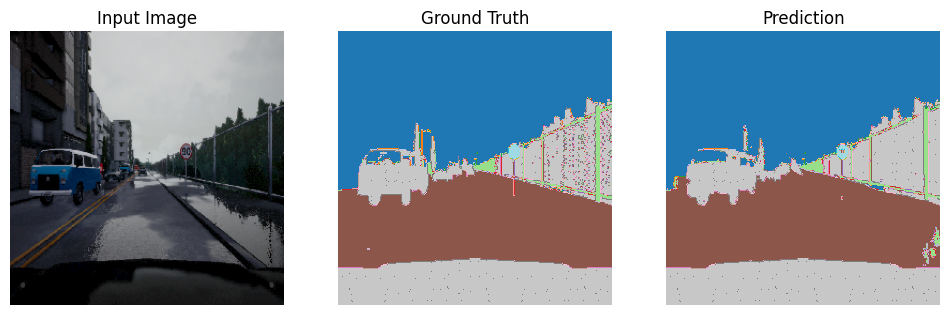

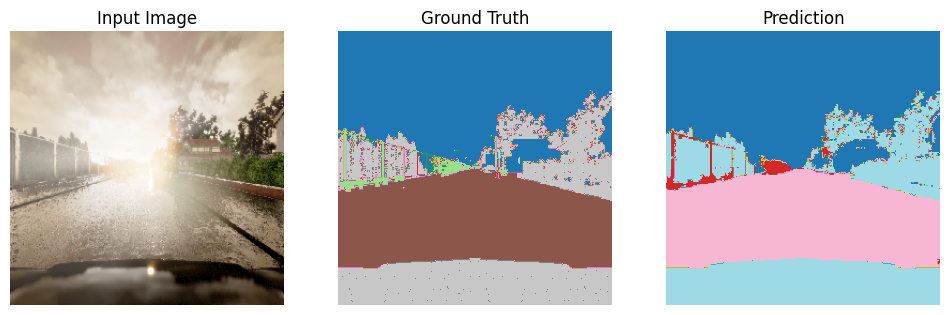

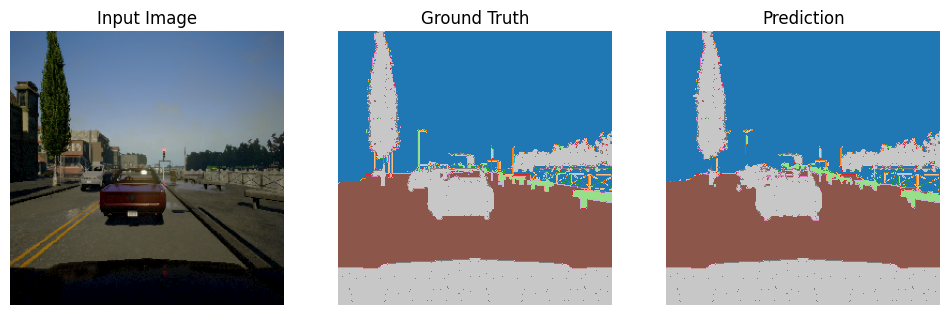

In [17]:
visualize_predictions(model_resunet, test_loader, device)

## 4. Gated Attention U-Net

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi  # α = 1 as per instruction

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=13):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionGate(512, 512, 256)
        self.dec4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionGate(256, 256, 128)
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(128, 128, 64)
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionGate(64, 64, 32)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(F.max_pool2d(x1, 2))
        x3 = self.enc3(F.max_pool2d(x2, 2))
        x4 = self.enc4(F.max_pool2d(x3, 2))
        x5 = self.bottleneck(F.max_pool2d(x4, 2))

        # Decoder with Attention Gates
        d4 = self.upconv4(x5)
        x4 = self.att4(g=d4, x=x4)
        d4 = self.dec4(torch.cat([d4, x4], dim=1))

        d3 = self.upconv3(d4)
        x3 = self.att3(g=d3, x=x3)
        d3 = self.dec3(torch.cat([d3, x3], dim=1))

        d2 = self.upconv2(d3)
        x2 = self.att2(g=d2, x=x2)
        d2 = self.dec2(torch.cat([d2, x2], dim=1))

        d1 = self.upconv1(d2)
        x1 = self.att1(g=d1, x=x1)
        d1 = self.dec1(torch.cat([d1, x1], dim=1))

        return self.final_conv(d1)


In [44]:
# Initialize
modelAttention = AttentionUNet(in_channels=3, out_channels=13).to(device)

# Train
train_losses_att, val_losses_att, train_ious_att, val_ious_att = train_model(
    modelAttention, train_loader, val_loader, device, epochs=50, lr=1e-4, save_path="attention_unet.pth"
)



Epoch 1/50


Train Loss: 0.8170 | mIoU: 0.5251
Val   Loss: 0.4055 | mIoU: 0.6340
 Best model saved to attention_unet.pth

Epoch 2/50


Train Loss: 0.3154 | mIoU: 0.6813
Val   Loss: 0.2976 | mIoU: 0.6818
 Best model saved to attention_unet.pth

Epoch 3/50


Train Loss: 0.2526 | mIoU: 0.7130
Val   Loss: 0.2240 | mIoU: 0.7263
 Best model saved to attention_unet.pth

Epoch 4/50


Train Loss: 0.2217 | mIoU: 0.7338
Val   Loss: 0.2180 | mIoU: 0.7365
 Best model saved to attention_unet.pth

Epoch 5/50


Train Loss: 0.1977 | mIoU: 0.7488
Val   Loss: 0.1840 | mIoU: 0.7554
 Best model saved to attention_unet.pth

Epoch 6/50


Train Loss: 0.1867 | mIoU: 0.7563
Val   Loss: 0.1784 | mIoU: 0.7578
 Best model saved to attention_unet.pth

Epoch 7/50


Train Loss: 0.1663 | mIoU: 0.7683
Val   Loss: 0.2372 | mIoU: 0.7437

Epoch 8/50


Train Loss: 0.1582 | mIoU: 0.7721
Val   Loss: 0.1477 | mIoU: 0.7709
 Best model saved to attention_unet.pth

Epoch 9/50


Train Loss: 0.1471 | mIoU: 0.7785
Val   Loss: 0.1410 | mIoU: 0.7764
 Best model saved to attention_unet.pth

Epoch 10/50


Train Loss: 0.1438 | mIoU: 0.7808
Val   Loss: 0.1362 | mIoU: 0.7796
 Best model saved to attention_unet.pth

Epoch 11/50


Train Loss: 0.1298 | mIoU: 0.7895
Val   Loss: 0.1301 | mIoU: 0.7885
 Best model saved to attention_unet.pth

Epoch 12/50


Train Loss: 0.1221 | mIoU: 0.7944
Val   Loss: 0.1249 | mIoU: 0.7881

Epoch 13/50


Train Loss: 0.1178 | mIoU: 0.7977
Val   Loss: 0.1138 | mIoU: 0.7908
 Best model saved to attention_unet.pth

Epoch 14/50


Train Loss: 0.1146 | mIoU: 0.7999
Val   Loss: 0.1127 | mIoU: 0.7930
 Best model saved to attention_unet.pth

Epoch 15/50


Train Loss: 0.1057 | mIoU: 0.8061
Val   Loss: 0.1062 | mIoU: 0.7997
 Best model saved to attention_unet.pth

Epoch 16/50


Train Loss: 0.0992 | mIoU: 0.8113
Val   Loss: 0.1065 | mIoU: 0.7995

Epoch 17/50


Train Loss: 0.0942 | mIoU: 0.8145
Val   Loss: 0.0964 | mIoU: 0.8059
 Best model saved to attention_unet.pth

Epoch 18/50


Train Loss: 0.0898 | mIoU: 0.8175
Val   Loss: 0.0915 | mIoU: 0.8077
 Best model saved to attention_unet.pth

Epoch 19/50


Train Loss: 0.0855 | mIoU: 0.8209
Val   Loss: 0.0880 | mIoU: 0.8122
 Best model saved to attention_unet.pth

Epoch 20/50


Train Loss: 0.0830 | mIoU: 0.8224
Val   Loss: 0.0889 | mIoU: 0.8122
 Best model saved to attention_unet.pth

Epoch 21/50


Train Loss: 0.0769 | mIoU: 0.8275
Val   Loss: 0.0800 | mIoU: 0.8178
 Best model saved to attention_unet.pth

Epoch 22/50


Train Loss: 0.0776 | mIoU: 0.8268
Val   Loss: 0.0789 | mIoU: 0.8185
 Best model saved to attention_unet.pth

Epoch 23/50


Train Loss: 0.0709 | mIoU: 0.8314
Val   Loss: 0.0782 | mIoU: 0.8179

Epoch 24/50


Train Loss: 0.0687 | mIoU: 0.8312
Val   Loss: 0.0731 | mIoU: 0.8230
 Best model saved to attention_unet.pth

Epoch 25/50


Train Loss: 0.0638 | mIoU: 0.8366
Val   Loss: 0.0737 | mIoU: 0.8233
 Best model saved to attention_unet.pth

Epoch 26/50


Train Loss: 0.0662 | mIoU: 0.8346
Val   Loss: 0.0737 | mIoU: 0.8205

Epoch 27/50


Train Loss: 0.8255 | mIoU: 0.6654
Val   Loss: 0.6713 | mIoU: 0.6294

Epoch 28/50


Train Loss: 0.5977 | mIoU: 0.6518
Val   Loss: 0.6125 | mIoU: 0.6457

Epoch 29/50


Train Loss: 0.5269 | mIoU: 0.6676
Val   Loss: 0.9851 | mIoU: 0.5540

Epoch 30/50


Train Loss: 0.4753 | mIoU: 0.6803
Val   Loss: 0.9002 | mIoU: 0.5363

Epoch 31/50


Train Loss: 0.4495 | mIoU: 0.6853
Val   Loss: 0.7390 | mIoU: 0.6428

Epoch 32/50


Train Loss: 0.4275 | mIoU: 0.6915
Val   Loss: 0.7836 | mIoU: 0.5619

Epoch 33/50


Train Loss: 0.4095 | mIoU: 0.6956
Val   Loss: 1.2810 | mIoU: 0.3244

Epoch 34/50


Train Loss: 0.3902 | mIoU: 0.7013
Val   Loss: 0.4649 | mIoU: 0.6577

Epoch 35/50


Train Loss: 0.3862 | mIoU: 0.7028
Val   Loss: 0.4724 | mIoU: 0.6666

Epoch 36/50


Train Loss: 0.3714 | mIoU: 0.7069
Val   Loss: 0.4733 | mIoU: 0.6680

Epoch 37/50


Train Loss: 0.3726 | mIoU: 0.7061
Val   Loss: 0.7371 | mIoU: 0.4949

Epoch 38/50


Train Loss: 0.3594 | mIoU: 0.7106
Val   Loss: 0.6372 | mIoU: 0.6168

Epoch 39/50


Train Loss: 0.3543 | mIoU: 0.7118
Val   Loss: 0.4117 | mIoU: 0.6786

Epoch 40/50


Train Loss: 0.3531 | mIoU: 0.7122
Val   Loss: 1.1233 | mIoU: 0.5573

Epoch 41/50


Train Loss: 0.3543 | mIoU: 0.7113
Val   Loss: 0.6689 | mIoU: 0.6529

Epoch 42/50


Train Loss: 0.3336 | mIoU: 0.7174
Val   Loss: 0.4223 | mIoU: 0.6880

Epoch 43/50


Train Loss: 0.3282 | mIoU: 0.7194
Val   Loss: 0.3800 | mIoU: 0.7021

Epoch 44/50


Train Loss: 0.3215 | mIoU: 0.7212
Val   Loss: 0.3417 | mIoU: 0.7072

Epoch 45/50


Train Loss: 0.3186 | mIoU: 0.7230
Val   Loss: 1.0076 | mIoU: 0.6277

Epoch 46/50


Train Loss: 0.3180 | mIoU: 0.7225
Val   Loss: 0.7399 | mIoU: 0.6185

Epoch 47/50


Train Loss: 0.3147 | mIoU: 0.7231
Val   Loss: 0.4883 | mIoU: 0.6750

Epoch 48/50


KeyboardInterrupt: 

In [ ]:
# Plot
plot_curves(train_losses_att, val_losses_att, train_ious_att, val_ious_att)

In [50]:
# Evaluate
evaluate_on_test(modelAttention, test_loader, device, checkpoint_path="/kaggle/working/attention_unet.pth")

<ipython-input-46-8cfcfcc2678f>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))
Testing: 100%|████


 Test mIoU (from /kaggle/working/attention_unet.pth): 0.8277


0.8276711702346802

In [ ]:
# Visualize
visualize_predictions(modelAttention, test_loader, device)